In [1]:
import math
import random
import yaml
import argparse
from dotmap import DotMap

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn.functional import cosine_similarity

import matplotlib.pyplot as plt
import wandb

In [2]:
import sys
sys.path.append("../src")  # make sure Python can find src/
import data
from model_linear import GPTLinear
from model_softmax import GPTSoftmax
# from train_step import train_step
from multi_task_train import train_step

In [3]:

def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    ## Not sure if below would work if I dont have gpu
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [4]:
def load_config(config_path: str):
    """Load YAML config and convert to DotMap."""
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    cfg = DotMap(cfg)
    return cfg


def prepare_data_samplers(config, device):
    """Create a dict of data samplers for each task."""
    num_task = len(config.data.tasks)
    data_samplers = {}
    for i in range(num_task):
        task = config.data.tasks[i]
        task_class = getattr(data, task.name)
        data_samplers[task.name] = task_class(task, device)
    return data_samplers

In [5]:
set_seed(67)

Seed set to 67


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
config = load_config("../src/configs/mix1_mws_mwp_2head.yaml")
n_tasks = len(config.data.tasks)
config.model.vocab_size = max(getattr(config.data, "p", 17), config.data.max_num) + n_tasks
config.model.block_size = 2 * config.data.num_tokens + 1
config.data.tasks[0].k=1

In [11]:
config.data.tasks

[DotMap(name='MovingWindowSum', sep=17, n_train=128, n_test=32, min_num=1, max_num=16, k=1, p=17),
 DotMap(name='MovingWindowProduct', sep=18, n_train=128, n_test=32, min_num=1, max_num=16, k=2, p=17)]

In [21]:
config.model.vocab_size

DotMap(_ipython_display_=DotMap(), _repr_mimebundle_=DotMap(), _repr_html_=DotMap(), _repr_markdown_=DotMap(), _repr_svg_=DotMap(), _repr_png_=DotMap(), _repr_pdf_=DotMap(), _repr_jpeg_=DotMap(), _repr_latex_=DotMap(), _repr_json_=DotMap(), _repr_javascript_=DotMap())

In [35]:
config

DotMap(model=DotMap(n_layer=1, n_head=2, n_embd=256, linear=True, vocab_size=19, block_size=33), data=DotMap(tasks=[DotMap(name='MovingWindowSum', sep=17, n_train=128, n_test=32, min_num=1, max_num=16, k=1, p=17), DotMap(name='MovingWindowProduct', sep=18, n_train=128, n_test=32, min_num=1, max_num=16, k=2, p=17)], min_num=1, max_num=16, k=2, p=17, cot=False, num_tokens=16, n_train=256, n_test=64, fixed_len=True, mix='random'), train=DotMap(lr=0.0001, grad_clip=-1, num_steps=1000, norm_type='none_rank', wandb=True, wandb_run_name='mix_mwsk2_mwpk2_linear_2head_embeddingNotFrozen_inputsMasked', wandb_project='loss_plateau_tf', save_ckpt=False, ckpt_freq=20, seed=67, mask_input=True, freeze_embedding=False, getdoc=DotMap()), _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [36]:
data_samplers = prepare_data_samplers(config, device)
model = GPTLinear(config.model, return_att=True).to(device)
optim = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.train.lr)

# WandB setup
if getattr(config.train, "wandb", False):
    wandb_run_name = "expresability_check_mwsk1_mwpk2_linear_2head_inputMasked_embeddingNotFrozen"
    wandb.login(key="")
    wandb.init(project=config.train.wandb_project, name=wandb_run_name, config=config)
    wandb.watch(model)
data_samplers

/home/jyue/.conda/envs/emerge/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jetyue04 (wth_ucsd). Use `wandb login --relogin` to force relogin


{'MovingWindowSum': <data.MovingWindowSum at 0x7ff9acf121c0>,
 'MovingWindowProduct': <data.MovingWindowProduct at 0x7ff9acf12250>}

Step 700 -- Train loss: 2.4310860633850098, Train Acc: 0.179443359375 Test Acc: 0.1748046875
Step 701 -- Train loss: 2.4324169158935547, Train Acc: 0.17919921875 Test Acc: 0.171875
Step 702 -- Train loss: 2.4309513568878174, Train Acc: 0.17431640625 Test Acc: 0.1767578125
Step 703 -- Train loss: 2.430447578430176, Train Acc: 0.177734375 Test Acc: 0.1640625
Step 704 -- Train loss: 2.4309844970703125, Train Acc: 0.180419921875 Test Acc: 0.1943359375
Step 705 -- Train loss: 2.4327499866485596, Train Acc: 0.181884765625 Test Acc: 0.1796875
Step 706 -- Train loss: 2.4303972721099854, Train Acc: 0.174560546875 Test Acc: 0.177734375
Step 707 -- Train loss: 2.4317896366119385, Train Acc: 0.180419921875 Test Acc: 0.1884765625
Step 708 -- Train loss: 2.430316686630249, Train Acc: 0.178466796875 Test Acc: 0.1787109375
Step 709 -- Train loss: 2.4293792247772217, Train Acc: 0.183837890625 Test Acc: 0.1806640625
Step 710 -- Train loss: 2.42950177192688, Train Acc: 0.18017578125 Test Acc: 0.1796875
S

KeyboardInterrupt: 

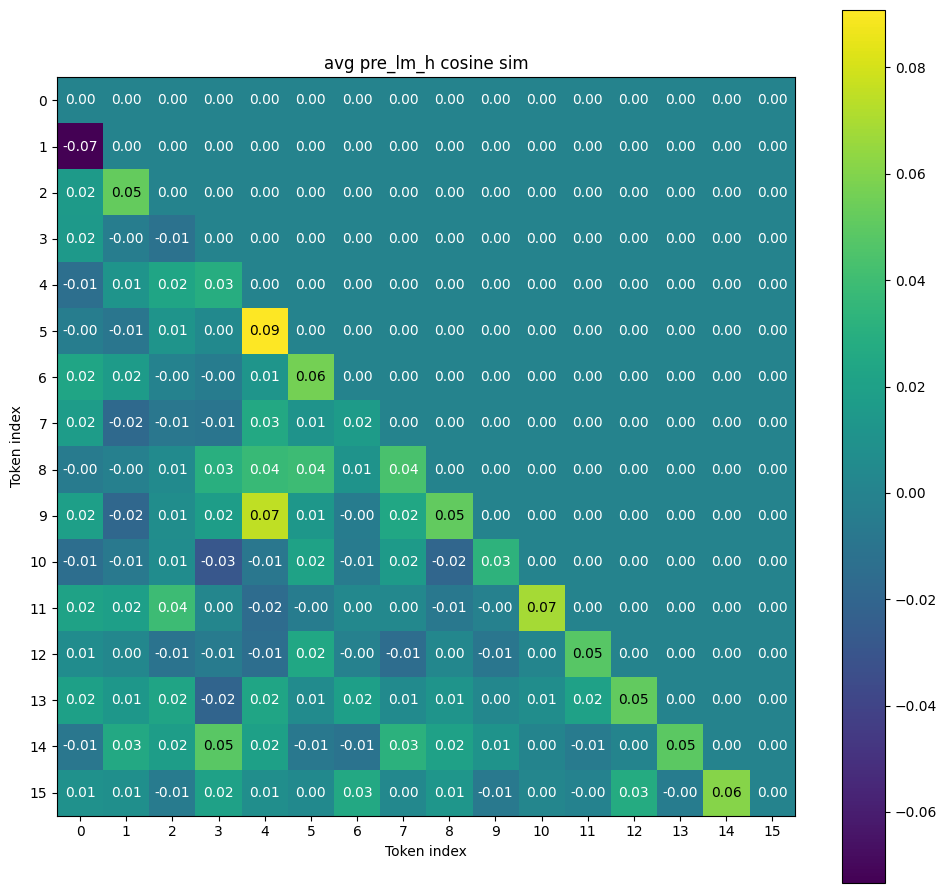

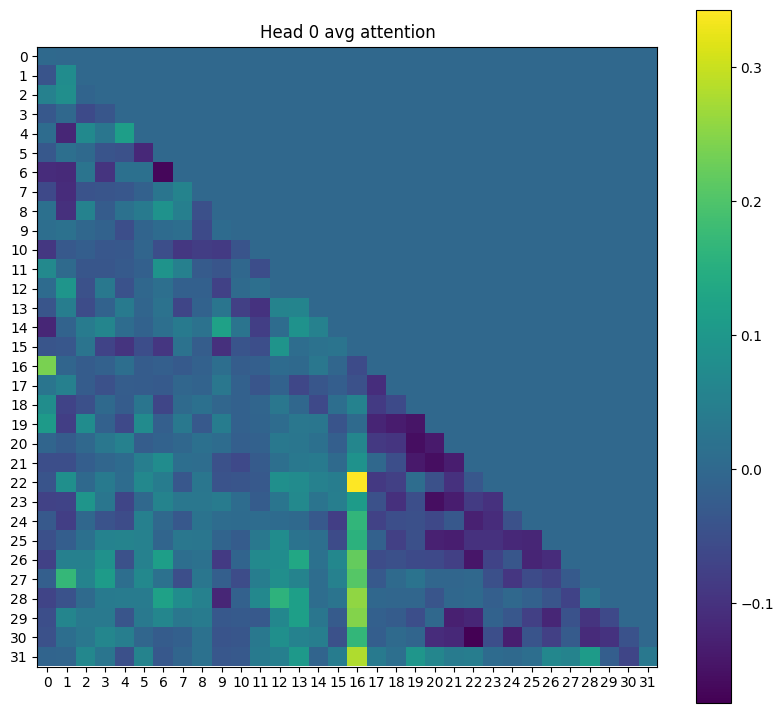

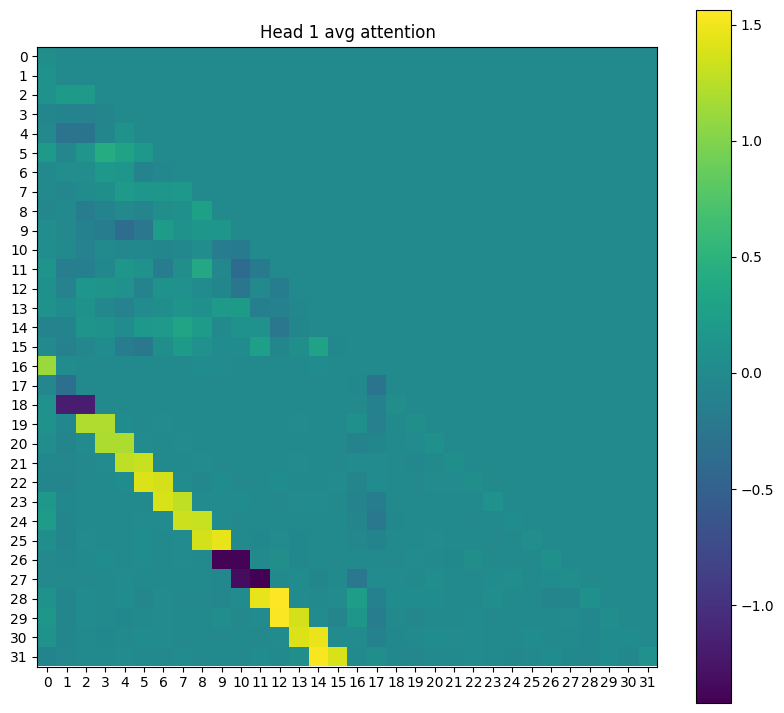

In [42]:
mwp_sampler = {k: v for k, v in data_samplers.items() if k == "MovingWindowProduct"}
for step in range(500):
    train_step(
            model=model,
            optim=optim,
            data_samplers=mwp_sampler,
            step=step+700,
            config=config,
            device=device,
        )


In [43]:
mwp_sampler = {k: v for k, v in data_samplers.items() if k == "MovingWindowProduct"}
for step in range(100):
    train_step(
            model=model,
            optim=optim,
            data_samplers=data_samplers,
            step=step+883,
            config=config,
            device=device,
        )

Step 883 -- Train loss: 2.6767020225524902, Train Acc: 0.5537109375 Test Acc: 0.5498046875
Step 884 -- Train loss: 1.6199541091918945, Train Acc: 0.54443359375 Test Acc: 0.5380859375
Step 885 -- Train loss: 1.5574432611465454, Train Acc: 0.449462890625 Test Acc: 0.455078125
Step 886 -- Train loss: 1.5769716501235962, Train Acc: 0.4443359375 Test Acc: 0.4619140625
Step 887 -- Train loss: 1.3965349197387695, Train Acc: 0.49169921875 Test Acc: 0.50390625
Step 888 -- Train loss: 1.166502833366394, Train Acc: 0.506103515625 Test Acc: 0.5068359375
Step 889 -- Train loss: 1.0055739879608154, Train Acc: 0.549072265625 Test Acc: 0.544921875
Step 890 -- Train loss: 1.004369854927063, Train Acc: 0.552734375 Test Acc: 0.556640625
Step 891 -- Train loss: 0.9820396900177002, Train Acc: 0.57373046875 Test Acc: 0.5654296875
Step 892 -- Train loss: 0.9144564867019653, Train Acc: 0.58837890625 Test Acc: 0.5625
Step 893 -- Train loss: 0.8353409767150879, Train Acc: 0.63427734375 Test Acc: 0.66796875
Step

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 883 is less than current step: 884. Dropping entry: {'MovingWindowSum/examples_seen': 113152, 'MovingWindowSum/train_loss': 5.323299407958984, 'MovingWindowSum/train_acc': 0.1103515625, 'MovingWindowSum/test_acc': 0.107421875, 'MovingWindowSum/input_seq': '4, 5, 4, 10, 8, 7, 16, 2, 4, 12, 8, 5, 5, 3, 1, 4, 17, 4, 5, 4, 10, 8, 7, 16, 2, 4, 12, 8, 5, 5, 3, 1, 4', 'MovingWindowSum/output_seq': '4, 5, 4, 10, 8, 7, 16, 2, 4, 12, 8, 5, 5, 3, 1, 4, 17, 12, 9, 3, 6, 12, 5, 10, 15, 8, 14, 11, 6, 8, 15, 3, 4', 'MovingWindowSum/mean_cosine_sim': 0.033977072685956955, 'MovingWindowSum/att_prog_measure': 0.2571047842502594, 'MovingWindowSum/idx0_check': 0.671875, 'MovingWindowSum/idx1_check': 0.0703125, 'MovingWindowSum/idx2_check': 0.09375, 'MovingWindowSum/idx3_check': 0.078125, 'MovingWindowSum/idx4_check'